**извлечение признаков из текста на естественном языке**

классификатор текстов

частотный анализ с очисткой стоп-слов (TF)

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200  

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [6]:
data.sample(2)

,text,tag
1988,"Главным экономическим советником Дональда Трампа может стать президент корпорации Goldman Sachs Гэри Кон. Главный экономический советник — один из ключевых финансовых постов в стране, напоминает т...",politics
3016,"Автомобильные эксперты страны составили ТОП-5 седанов, которые навсегда покинули автомобильный рынок России. Часть из них была снята с продаж в нашей стране по причине низких показателей объемов р...",auto


---

In [7]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian') )

In [8]:
%%time 

data['text_clean'] = data['text'].str.lower() # приведение в lowercase

# замена символов-разделителей (-,_) на пробел
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'_', ' ', s))

# замена цифр
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' ', s))

# делим строки на слова (токенизация)
data['text_clean'] = data['text_clean'].apply(lambda t: [ w.strip() for w in t.split() if len(w.strip())>2 ] )

# удаление лишних слов 
data['text_clean'] = data['text_clean'].apply(lambda t:[w for w in t if w not in stopwords])

# стемминг, выделение основы слова
# data['text_clean'] = data['text_clean'].apply( lambda t: Stemmer('russian').stemWords(t) )
data['text_clean'] = data['text_clean'].apply(lambda t:[ SnowballStemmer('russian').stem(w) for w in t if w])


CPU times: user 18.3 s, sys: 70.4 ms, total: 18.4 s
Wall time: 18.5 s


In [9]:
data['text_clean'] = data['text_clean'].apply(lambda t:' '.join(t))

In [10]:
data[['text_clean']].sample(2)

,text_clean
371,обнаруж след вирус вызыва болезн кавасак американск исследовател север западн университет сообщ все видим уда напаст след вирус котор вызыва болезн кавасак эт заболеван сам распространен причин пр...
2506,декабр баз киностуд ленфильм запланирова проведен всероссийск выставк историческ книг эт произойдет трет поэт надежд культурн мероприят преврат традицион ефрем русла выставк год явля особен посвящ...


##  CountVectorizer + TF

In [11]:
tf = TfidfVectorizer(use_idf=True,norm='l2')

# tf = TfidfVectorizer(use_idf=False,norm='l2')
tf.fit( data['text_clean'] )

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [12]:
len(tf.vocabulary_)

34798

## формируем датасеты

In [13]:
X = tf.transform( data['text_clean'] )
X.shape

(3196, 34798)

In [14]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [15]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

---

In [16]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.9, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((319, 34798), (319,), (2877, 34798), (2877,))

## обучаем

In [17]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.19,
       validation_fraction=0.1, verbose=0, warm_start=False)

## тестируем

In [18]:
o = clf.predict(X_train)

In [19]:
accuracy_score(y_train,o)

1.0

---

In [20]:
o = clf.predict(X_test)

In [21]:
accuracy_score(y_test,o)

0.7865832464372611

In [22]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.92      0.74      0.82       227
           1       0.74      0.85      0.79       319
           2       0.78      0.80      0.79       240
           3       0.33      0.17      0.23        86
           4       0.83      0.85      0.84       396
           5       0.84      0.87      0.86       542
           6       0.67      0.45      0.54        58
           7       0.64      0.51      0.57        41
           8       0.62      0.97      0.76       200
           9       0.55      0.34      0.42       133
          10       0.91      0.96      0.93       340
          11       0.83      0.70      0.76       262
          12       0.43      0.18      0.26        33

   micro avg       0.79      0.79      0.79      2877
   macro avg       0.70      0.65      0.66      2877
weighted avg       0.78      0.79      0.78      2877



---

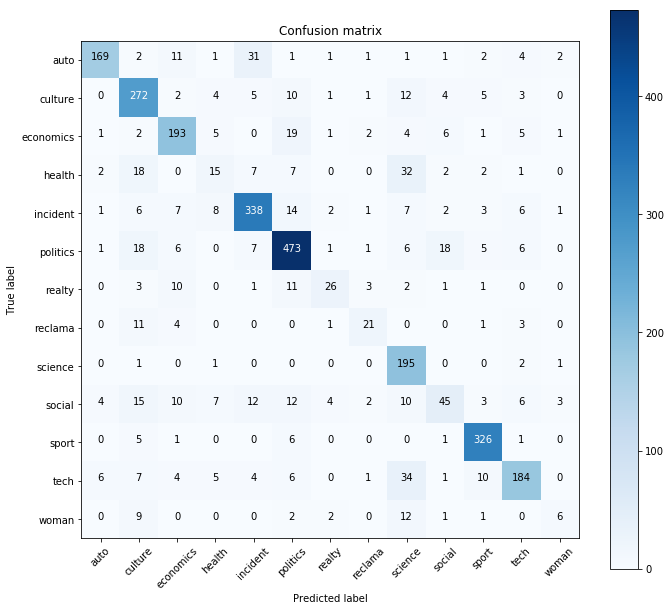

In [23]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [24]:
o = clf.predict(X)

In [25]:
labels_inv = { labels[k]:k for k in labels}
# labels_inv

In [26]:
i = np.random.randint(len(data))
print('tag:',data.iloc[i,1])
print('predict:',labels_inv[o[i]])
print('- - - - - - - - - - - - - - - - - - \n')
print(data.iloc[i,0])


tag: science
predict: science
- - - - - - - - - - - - - - - - - - 

На Земле нашли самое одинокое место: полюс недоступности, или Точка Немо -географическая точка в Тихом океане, максимально удаленная от людей.

Именно здесь можно оказаться в гордом одиночестве, на расстоянии 2,7 тысячи километров от людей и цивилизации. Кроме того, чтобы кто-то смог добраться до Точки Немо, потребуется в среднем 15 дней, потому что на самолете туда пути нет, а отправиться в одинокое место можно только на теплоходе.

Интересно, что на Земле уже существуют места для уставших от огромного количества людей. К примеру, архипелаг Тристан-да-Кунья — самое удаленное место на Земле, где живет всего 264 человека. Самое близкое к островной цепи место, где живут люди, находится на расстоянии 2 тысяч км. Еще одно крайне уединенное место — остров Девон в Канаде размером с Хорватию, но на нем нет ни одной живой души. На соседнем острове, в 80 км от Девона, однако, проживают целых 229 человек.

фото zak-kor.net

След